## Main Process:

1. **Data Loading and Preprocessing:** Load image data, preprocess it by converting to grayscale, resizing, and extracting features like HOG.
2. **Classifier Exploration:** Experiment with various classifier models such as SVM, KNN, and Voting Classifier.
3. **Hyperparameter Tuning:** Utilize techniques like GridSearchCV to find the best hyperparameters for the SVM classifier with HOG features.
4. **Model Evaluation:** Evaluate the performance of each classifier using metrics like accuracy, precision, recall, and F1-score.
5. **Model Comparison:** Compare the performance of different classifiers using ROC curves and area under the curve (AUC).
6. **Model Saving:** Save the best-performing model for future use.
7. **Visualization:** Visualize the ROC curves for different classifiers to understand their performance visually.


## Summary

1. **Classifier Exploration:** We explored various classifier models, including Support Vector Machine (SVM) and k-Nearest Neighbors (KNN), to classify images.
2. **Feature Representation:** Experimented with both raw pixel data and Histogram of Oriented Gradients (HOG) features for image classification.
3. **Data Preprocessing:** Applied techniques like Synthetic Minority Over-sampling Technique (SMOTE) for dealing with class imbalance and StandardScaler for feature scaling.
4. **Model Optimization:** Optimized the SVM classifier with HOG features using GridSearchCV to find the best hyperparameters.
5. **Model Saving:** Saved the best-performing model using joblib for future use.
6. **Visualization:** Visualized the Receiver Operating Characteristic (ROC) curves for different classifiers using matplotlib, highlighting the area under the curve (AUC) to evaluate their performance.



In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import numpy as np
import os
from PIL import Image
import cv2
import joblib  

SIZE = 224

base_dir = "stamp_data"
fake_dir = os.path.join(base_dir, "fake")
real_dir = os.path.join(base_dir, "real")

# Lists to store real and fake images
real_images = []
fake_images = []

def is_image(filename):
    try:
        with Image.open(filename) as img:
            img.verify()  
        return True
    except (IOError, OSError) as e:
        return False

for filename in os.listdir(fake_dir)[:100]:  # Limiting to first 100 images for faster processing
    img_path = os.path.join(fake_dir, filename)
    if is_image(img_path):
        try:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = np.array(img)
            img = cv2.resize(img, (SIZE, SIZE))
            fake_images.append(img)
        except Exception as e:
            print(f"Skipping non-image file: {img_path}, Error: {e}")

for filename in os.listdir(real_dir)[:100]:  # Limiting to first 100 images for faster processing
    img_path = os.path.join(real_dir, filename)
    if is_image(img_path):
        try:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = np.array(img)
            img = cv2.resize(img, (SIZE, SIZE))
            real_images.append(img)
        except Exception as e:
            print(f"Skipping non-image file: {img_path}, Error: {e}")
# onvert the lists of images into NumPy arrays 
real_images = np.array(real_images)
fake_images = np.array(fake_images)

#Create labels , respectively, where 0 represents real stamps and 1 represents fake stamps. 
real_labels = np.zeros((real_images.shape[0], 1))
fake_labels = np.ones((fake_images.shape[0], 1))
images = np.concatenate((real_images, fake_images))
labels = np.concatenate((real_labels, fake_labels))
images = images.reshape(images.shape[0], -1)

# The training set comprises 80% of the data.
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


In [33]:

smote = SMOTE(random_state=42)
train_data, train_labels = smote.fit_resample(train_data, train_labels)

param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear'], 
    'gamma': ['scale'] 
}

#  to find the best hyperparameters for the SVM classifier. 
grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=2)  # Using fewer folds for faster processing
grid_search.fit(train_data, train_labels.ravel())

print("Best Parameters:", grid_search.best_params_)

best_estimator = grid_search.best_estimator_
predictions = best_estimator.predict(test_data)

report = classification_report(test_labels, predictions)
print("Classification Report:\n", report)




Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.57      0.71        21
         1.0       0.67      0.95      0.78        19

    accuracy                           0.75        40
   macro avg       0.79      0.76      0.74        40
weighted avg       0.80      0.75      0.74        40



In [34]:
from sklearn.neighbors import KNeighborsClassifier
# KNN Model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_data, train_labels.ravel())

predictions_knn = knn.predict(test_data)

report_knn = classification_report(test_labels, predictions_knn)
print("KNN Classification Report:\n", report_knn)


KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.24      0.37        21
         1.0       0.53      0.95      0.68        19

    accuracy                           0.57        40
   macro avg       0.68      0.59      0.52        40
weighted avg       0.69      0.57      0.52        40



In [35]:
from skimage.feature import hog

hog_features = []
for image in images_combined:
    fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
    hog_features.append(fd)
hog_features = np.array(hog_features)

train_data_hog, test_data_hog, train_labels_hog, test_labels_hog = train_test_split(hog_features, labels_combined, test_size=0.2, random_state=42)

scaler_hog = StandardScaler()
train_data_hog_scaled = scaler_hog.fit_transform(train_data_hog)
test_data_hog_scaled = scaler_hog.transform(test_data_hog)

smote = SMOTE(random_state=42)
train_data_resampled, train_labels_resampled = smote.fit_resample(train_data_hog_scaled, train_labels_hog)

knn_hog = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors
knn_hog.fit(train_data_resampled, train_labels_resampled)

predictions_knn_hog = knn_hog.predict(test_data_hog_scaled)

report_knn_hog = classification_report(test_labels_hog, predictions_knn_hog)
print("KNN with HOG Features Classification Report:\n", report_knn_hog)


KNN with HOG Features Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.76      0.73        21
         1.0       0.71      0.63      0.67        19

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.70      0.70      0.70        40



In [36]:
hog_features = []
for image in images_combined:
    fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
    hog_features.append(fd)
hog_features = np.array(hog_features)

train_data, test_data, train_labels, test_labels = train_test_split(hog_features, labels_combined, test_size=0.2, random_state=42)
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

smote = SMOTE(random_state=42)
train_data_resampled, train_labels_resampled = smote.fit_resample(train_data_scaled, train_labels)

svm_classifier_hog = SVC(class_weight='balanced', kernel='linear', gamma='scale')
svm_classifier_hog.fit(train_data_resampled, train_labels_resampled)

predictions_svm_hog = svm_classifier_hog.predict(test_data_hog_scaled)

report_svm_hog = classification_report(test_labels_hog, predictions_svm_hog)
print("SVM with HOG Features Classification Report:\n", report_svm_hog)


SVM with HOG Features Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.57      0.67        21
         1.0       0.64      0.84      0.73        19

    accuracy                           0.70        40
   macro avg       0.72      0.71      0.70        40
weighted avg       0.72      0.70      0.70        40



In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_classifier_hog = SVC(class_weight='balanced')
grid_search = GridSearchCV(svm_classifier_hog, param_grid, cv=5)
grid_search.fit(train_data_resampled, train_labels_resampled)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_svm_classifier_hog = grid_search.best_estimator_
joblib.dump(best_svm_classifier_hog, 'stamp_svm_model_with_hog.joblib')
predictions_svm_hog = best_svm_classifier_hog.predict(test_data_hog_scaled)

report_svm_hog = classification_report(test_labels_hog, predictions_svm_hog)
print("SVM with HOG Features Classification Report (after optimization):\n", report_svm_hog)

Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM with HOG Features Classification Report (after optimization):
               precision    recall  f1-score   support

         0.0       0.86      0.57      0.69        21
         1.0       0.65      0.89      0.76        19

    accuracy                           0.72        40
   macro avg       0.76      0.73      0.72        40
weighted avg       0.76      0.72      0.72        40



In [38]:
from sklearn.ensemble import VotingClassifier

svm_classifier = SVC(class_weight='balanced', kernel='linear', gamma='scale')
knn_classifier = KNeighborsClassifier(n_neighbors=3)
estimators = [('svm', svm_classifier), ('knn', knn_classifier)]

voting_classifier = VotingClassifier(estimators, voting='hard')
voting_classifier.fit(train_data, train_labels.ravel())

predictions_voting = voting_classifier.predict(test_data)

report_voting = classification_report(test_labels, predictions_voting)
print("Voting Classifier Classification Report:\n", report_voting)


Voting Classifier Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.76      0.70        21
         1.0       0.67      0.53      0.59        19

    accuracy                           0.65        40
   macro avg       0.65      0.64      0.64        40
weighted avg       0.65      0.65      0.64        40



In [39]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(train_data, train_labels.ravel())

predictions_rf = random_forest.predict(test_data)

report_rf = classification_report(test_labels, predictions_rf)
print("Random Forest Classification Report:\n", report_rf)


Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.62      0.68        21
         1.0       0.65      0.79      0.71        19

    accuracy                           0.70        40
   macro avg       0.71      0.70      0.70        40
weighted avg       0.71      0.70      0.70        40



### Receiver Operating Characteristic (ROC) curves for different classifiers 

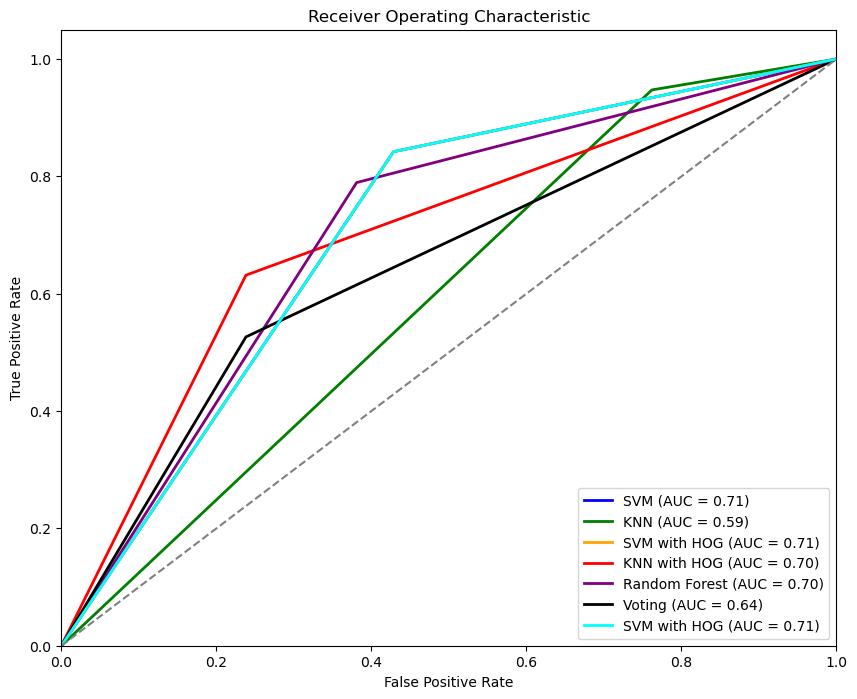

In [40]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for SVM
fpr_svm, tpr_svm, _ = roc_curve(test_labels, predictions_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Compute ROC curve and ROC area for KNN
fpr_knn, tpr_knn, _ = roc_curve(test_labels, predictions_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Compute ROC curve and ROC area for KNN with HOG
fpr_knn_hog, tpr_knn_hog, _ = roc_curve(test_labels_hog, predictions_knn_hog)
roc_auc_knn_hog = auc(fpr_knn_hog, tpr_knn_hog)

# Compute ROC curve and ROC area for SVM with HOG
fpr_svm_hog, tpr_svm_hog, _ = roc_curve(test_labels_hog, predictions_svm_hog)
roc_auc_svm_hog = auc(fpr_svm_hog, tpr_svm_hog)


# Compute ROC curve and ROC area for Voting Classifier
fpr_voting, tpr_voting, _ = roc_curve(test_labels, predictions_voting)
roc_auc_voting = auc(fpr_voting, tpr_voting)

# Compute ROC curve and ROC area for RandomForestClassifier
fpr_rf, tpr_rf, _ = roc_curve(test_labels, predictions_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Compute ROC curve and ROC area for the best SVM classifier with HOG features
fpr_svm_hog, tpr_svm_hog, _ = roc_curve(test_labels_hog, predictions_svm_hog)
roc_auc_svm_hog = auc(fpr_svm_hog, tpr_svm_hog)


# Plot ROC curves for all classifiers
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % roc_auc_knn)
plt.plot(fpr_svm_hog, tpr_svm_hog, color='orange', lw=2, label='SVM with HOG (AUC = %0.2f)' % roc_auc_svm_hog)
plt.plot(fpr_knn_hog, tpr_knn_hog, color='red', lw=2, label='KNN with HOG (AUC = %0.2f)' % roc_auc_knn_hog)
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_voting, tpr_voting, color='black', lw=2, label='Voting (AUC = %0.2f)' % roc_auc_voting)
plt.plot(fpr_svm_hog, tpr_svm_hog, color='cyan', lw=2, label='SVM with HOG (AUC = %0.2f)' % roc_auc_svm_hog)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
